In [54]:
import pandas
import matplotlib as plt
%matplotlib inline
import csv
import seaborn as sls
from scipy.stats import kendalltau
from time import time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import cv2
import numpy as np
from pylab import *
from scipy.spatial import distance
from scipy.ndimage import interpolation
import tables
import random as pyrandom
from sklearn import neighbors
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')


In [26]:
train_set = pandas.read_csv("train.csv")
x = train_set.ix[: , 1:]
x = np.array(x, dtype = 'float64') 

In [ ]:
images_impoved = []
for i in range(41999):
    elem = np.array(data[i:i+1])[0]
    temp = []
    for el in elem:
        for ele in el:
            temp.append(ele)
    images_impoved.append(temp)

In [27]:
def convert(frame):
    return frame.iloc[:,1:].values

def show_pic(img):
    img = img.reshape(28,28)
    #plt.pyplot.axis('off')
    plt.pyplot.imshow(img, interpolation='nearest')

def save_pic(img):
    #plt.pyplot.savefig('img.jpg', bbox_inches='tight')
    plt.pyplot.savefig('img.jpg')

def deskew (image):  
    affine_flags = cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR
    size = len(image)
    m = cv2.moments(image)
    
    if abs(m['mu02']) < 1e2:
        return image.copy()

    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, 0.5 * size * skew], [0 , 1 , 0]])
    image = cv2.warpAffine(image , M , (size , size) , flags = affine_flags)
    return image

Выравнивание

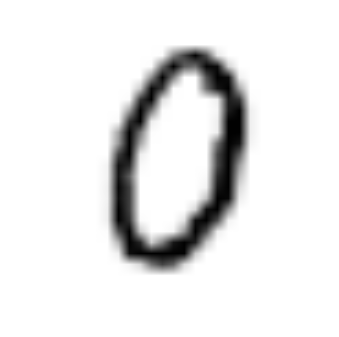

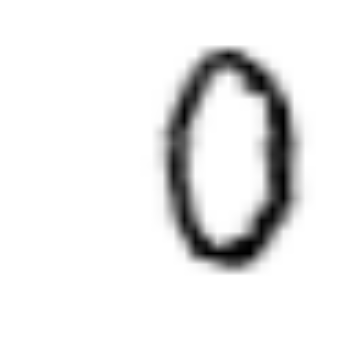

In [28]:
i = 5
plt.axis('off')
plt.imshow(x[i].reshape(28,28))

plt.figure()
plt.axis('off')
plt.imshow(deskew(x[i].reshape(28,28)),)

In [ ]:
images = []
skew = [] 
    
for row in log_progress(x):
    image = row.reshape(28 , 28)
    skewed_image = deskew(image)
    images.append(skewed_image)
    skew.append(skewed_image.flatten())
    x = np.array(skew, dtype = 'float64' )

In [ ]:
images_impoved = []
for elem in images:
    temp = []
    for el in elem.flat:
        temp.append(el)
    images_impoved.append(temp)

In [ ]:
csv.writer(open('images.csv', 'w'), dialect='excel').writerows(images)

In [29]:
y = train_set.label

X_train, X_test, y_train, y_test = cross_validation.train_test_split(images_improved, y, test_size=0.2, random_state=0)

In [35]:
n_jobs = -1

print("Started to fitting KNN on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

accuracy_values = []
for number in range(1,3):
    t0 = time()

    clf = neighbors.KNeighborsClassifier(number, n_jobs=n_jobs, weights='uniform')

    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    
    temp_acc = accuracy_score(y_test, y_predict)
    print('We have ', temp_acc, 'of accuracy on KNN with ', number, ' neighbor')
    accuracy_values.append(temp_acc)
    print("done in %0.3fs" % (time() - t0))
    print()

Started to fitting KNN on data with 8 cores...
We have  0.970952380952 of accuracy on KNN with  1  neighbor
done in 88.428s

We have  0.964404761905 of accuracy on KNN with  2  neighbor
done in 88.318s



In [36]:
print("Started to fitting poly SVM on data")

accuracy_values_poly_SVM = []
for number in range(2,4):
    t0 = time()

    clf = SVC(kernel='poly', degree=number)

    clf.fit(X_train, y_train)

    y_predict = clf.predict(X_test)
    
    temp_acc = accuracy_score(y_test, y_predict)
    print('We have ', temp_acc, 'of accuracy on poly SVC with degree =', number)
    accuracy_values_poly_SVM.append(temp_acc)
    print("done in %0.3fs" % (time() - t0))
    print()

Started to fitting poly SVM on data
We have  0.977738095238 of accuracy on poly SVC with degree = 2
done in 176.522s

We have  0.974047619048 of accuracy on poly SVC with degree = 3
done in 175.887s



In [37]:
n_jobs = -1

print("Started to fitting ExtraTreesClassifier on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

t0 = time()

forest = ExtraTreesClassifier(n_estimators=1000,
                              max_features=128,
                              n_jobs=n_jobs,
                              random_state=0)

forest.fit(X_train, y_train)

y_predict = forest.predict(X_test)

print('we have ', accuracy_score(y_test, y_predict), 'of accuracy on ExtraTreeClassifier')

print("done in %0.3fs" % (time() - t0))

Started to fitting ExtraTreesClassifier on data with 8 cores...
we have  0.97119047619 of accuracy on ExtraTreeClassifier
done in 249.393s


Никакого прироста в точности =(

Эрозия и дилатация

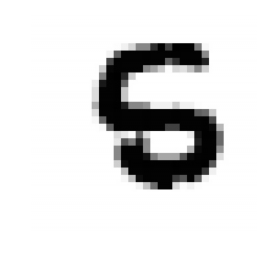

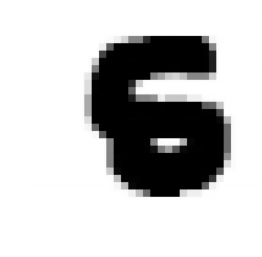

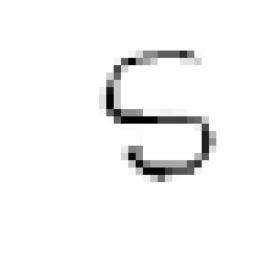

In [39]:
img = cv2.imread('img.jpg', 0)

kernel = np.ones((23,23), np.uint8)

img_erosion = cv2.erode(img, kernel, iterations=1)
img_dilation = cv2.dilate(img, kernel, iterations=1)

plt.axis('off')

plt.imshow(img , cmap = 'gray', interpolation = 'bicubic')
plt.figure()
plt.axis('off')
plt.imshow(img_erosion, cmap = 'gray', interpolation = 'bicubic')
plt.figure()
plt.axis('off')
plt.imshow(img_dilation, cmap = 'gray', interpolation = 'bicubic')

In [ ]:
Скелет алгоритмом Розенфильда

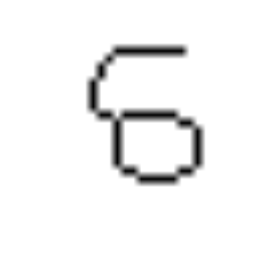

In [46]:
from skimage.morphology import skeletonize
from skimage import draw

image = x[19]

for i in range(len(image)):
    if image[i] > 0:
        image[i] = 1

skeleton = skeletonize(image.reshape(28,28))
plt.axis('off')
plt.imshow(skeleton)

 Попробуем добавить новые фичи

In [50]:
train_set = pandas.read_csv("train.csv")
x = train_set.ix[: , 1:]
x = list(np.array(x, dtype = 'float64'))
y = train_set.label

Простая статистика количества заполненных\пустых клеток и их отношение

In [58]:
x = np.array(x)
x_ls = []
for i in range(len(x)):
    temp = []
    white = 0
    black = 0
    for elem in x[i]:
        temp.append(elem)
        if elem > 0:
            black += 1
        else:
            white += 1
    temp.append(white)
    temp.append(black)
    temp.append(white/black)
    x_ls.append(temp)

In [66]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x_ls, y, test_size=0.2, random_state=0)

In [67]:
n_jobs = -1

print("Started to fitting ExtraTreesClassifier on data with %d cores..." % 8 if n_jobs == -1 else n_jobs)

t0 = time()

forest = ExtraTreesClassifier(n_estimators=500,
                              max_features=128,
                              n_jobs=n_jobs,
                              random_state=0)


forest.fit(X_train, y_train)

y_predict = forest.predict(X_test)

print('we have ', accuracy_score(y_test, y_predict), 'of accuracy on ExtraTreeClassifier')

print("done in %0.3fs" % (time() - t0))

importances = forest.feature_importances_

Started to fitting ExtraTreesClassifier on data with 8 cores...
we have  0.970714285714 of accuracy on ExtraTreeClassifier
done in 121.077s


In [69]:
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(np.array(x_ls).shape[1]):
    if indices[f] >= 784:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
3. feature 786 (0.011099)
6. feature 784 (0.009398)
12. feature 785 (0.007731)


Получаем, что данные характеристики очень важны при классификации.